In [75]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import combinations_with_replacement
import libpysal.weights as lpw

In [57]:
# set seed
seed_value = 42
np.random.seed(seed_value)

In [58]:
# coordinates function
def make_coords(N_points, xm, xM, ym, yM):
    
    # Define the range of coordinate values
    xmin, ymin = xm, ym
    xmax, ymax = xM, yM
    
    x_coords = np.random.uniform(xmin, xmax, size=N_points)
    y_coords = np.random.uniform(ymin, ymax, size=N_points)
    coords = np.column_stack((x_coords, y_coords))
    return coords
    

In [59]:
# make coordinates
N = 1000
coords = make_coords(N, 0, 10, 0, 10)

In [60]:
# calculate inverse matrix A
# function that makes weight matrix
def make_weight(coords, thres):
    w = lpw.DistanceBand.from_array(coords, threshold=thres, binary=True)
    w.transform = 'R'
    return w.full()[0]


# function that checks if the matrix is invertible
def check_invertible(matrix):
    try:
        inverse = np.linalg.inv(matrix)
        return inverse
    except np.linalg.LinAlgError:
        return False

    
# function that calculates A
def get_A(coords, N, thres, rho):
    
    # make weight matrix
    W = make_weight(coords, thres)
    
    # calculate (I - rho * W)
    I = np.identity(N)
    X = I - rho * W
    
    # get A
    A = check_invertible(X)
    
    return A

In [61]:
# simulation
# set up parameters
n = 10000
threshold = 9 
rho = 0.5 

# calculate invertible matrix A
A = get_A(coords, N, threshold, rho)

results = [] # generated n * y = [y1, y2, ..., yN]
V = [] # randomly generated v = [v1, v2, ..., vD], (D = N)

# run simulations
for i in range(n):
    # Generate random v from standard normal distribution
    v = np.random.randn(N, 1) 
    V.append(v)
    # Compute the matrix product
    y = np.dot(A, v) # y = N x 1 vector
    results.append(y)
    
    # if i % 10 == 0:
    #     print(f"Iteration: {i+1} / {n}")
    #     print("The shape of the simulation result is: ", np.shape(results))


print("The shape of the simulation result is: ", np.shape(results)) # (n, N, 1), cf. 3D array

The shape of the simulation result is:  (10000, 1000, 1)


In [62]:
# convert results into dataframe (n, N) 
# make a column names list; y1, y2, ..
col_names = []

for i in range(N):
    col_names.append('y{}'.format(i+1))

simul_df = pd.DataFrame(np.reshape(results, (n, N)), columns=col_names)

print(simul_df)

            y1        y2        y3        y4        y5        y6        y7   
0    -0.863544 -0.811690 -0.208277  0.380240  0.927843 -0.787119  1.510815  \
1     1.876475  0.391002 -0.860441  0.536896 -2.635149  0.006285  0.337410   
2     0.287743  2.445429 -1.895945 -0.092760  0.577659  0.063014 -0.178263   
3     0.854846 -0.991526 -0.105745 -0.319999 -1.029840  0.337789 -0.561040   
4    -0.222610  0.586214 -0.112207 -1.497315  0.028534  1.004614 -0.077201   
...        ...       ...       ...       ...       ...       ...       ...   
9995  1.084996  0.368943  1.087594 -0.853547 -1.427427 -0.276599 -0.414716   
9996 -0.885039 -2.805450  1.243790 -0.241250 -1.437430 -1.931792  1.253494   
9997 -1.016980  1.059141  0.749836 -1.316589 -0.748648  0.318839  0.884751   
9998 -1.419706 -0.826170 -0.498936  0.460752  0.604212 -1.562288 -0.454122   
9999  1.547202 -0.761756 -0.981272 -0.296529  1.376105  1.171483 -1.070560   

            y8        y9       y10  ...      y991      y992    

In [63]:
# calculate covariance between yi & yj
# get variance of vector V 
var = np.var(V)

# initialize an empty covariance matrix
cov_model = np.zeros((N, N))


for i in range(N):
  for k in range(N):
    for j in range(N):
      cov_model[i,k] += A[i,j] * A[k,j]
      cov_model[k,i] += A[i,j] * A[k,j]

cov_model = var * cov_model / 2

# convert results to dataframe
cov_model = pd.DataFrame(cov_model, columns=col_names, index=col_names)
cov_model

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y991,y992,y993,y994,y995,y996,y997,y998,y999,y1000
y1,1.002114,0.003083,0.003083,0.003087,0.003084,0.003085,0.003095,0.003085,0.003087,0.003088,...,0.003083,0.003084,0.003088,0.003091,0.003087,0.003091,0.001933,0.003117,0.003137,0.003088
y2,0.003083,1.002092,0.003129,0.003092,0.003075,0.003080,0.001948,0.003148,0.003091,0.003088,...,0.003128,0.003113,0.003087,0.003103,0.003085,0.003075,0.003181,0.001900,0.003196,0.003088
y3,0.003083,0.003129,1.002100,0.003091,0.003079,0.003082,0.003076,0.003158,0.003086,0.003087,...,0.003133,0.003081,0.003087,0.003080,0.003085,0.003078,0.003183,0.001915,0.003130,0.003087
y4,0.003087,0.003092,0.003091,1.002118,0.003086,0.003086,0.003086,0.003095,0.003089,0.003089,...,0.003091,0.003086,0.003089,0.003086,0.003088,0.003085,0.003121,0.003099,0.003136,0.003089
y5,0.003084,0.003075,0.003079,0.003086,1.002101,0.003115,0.003144,0.003079,0.003086,0.003087,...,0.003080,0.003079,0.003088,0.003080,0.003095,0.003127,0.003117,0.003085,0.001859,0.003087
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
y996,0.003091,0.003075,0.003078,0.003085,0.003127,0.003114,0.003140,0.003078,0.003085,0.003086,...,0.003079,0.003079,0.003087,0.003084,0.003094,1.002103,0.003105,0.003101,0.001873,0.003086
y997,0.001933,0.003181,0.003183,0.003121,0.003117,0.003116,0.003101,0.003230,0.003116,0.003117,...,0.003162,0.003107,0.003118,0.003103,0.003120,0.003105,1.002077,0.001778,0.001791,0.003117
y998,0.003117,0.001900,0.001915,0.003099,0.003085,0.003092,0.003114,0.001875,0.003104,0.003101,...,0.001934,0.003108,0.003101,0.003116,0.003098,0.003101,0.001778,1.002081,0.003167,0.003101
y999,0.003137,0.003196,0.003130,0.003136,0.001859,0.001896,0.001835,0.003144,0.003136,0.003132,...,0.003136,0.003170,0.003132,0.003163,0.001921,0.001873,0.001791,0.003167,1.002074,0.003132


In [64]:
# distance matrix
# initialize an empty distances matrix
distances = np.zeros((N, N))

# compute the euclidean distance between pair of coords
for i in range(N):
    for j in range(i+1, N):
        distances[i,j] = distances[j,i] = np.linalg.norm(coords[i] - coords[j])    

# convert distances to dataframe
distances = pd.DataFrame(distances, columns=col_names, index=col_names)
distances

,y1,y2,y3,y4,y5,y6,y7,y8,y9,y10,...,y991,y992,y993,y994,y995,y996,y997,y998,y999,y1000
y1,0.000000,6.776873,7.751515,5.912179,6.587296,5.216387,5.977787,8.262477,2.355864,4.514837,...,7.192776,3.212286,4.372506,2.213602,5.664046,5.501649,9.432852,2.645905,5.897723,1.205274
y2,6.776873,0.000000,3.967736,4.002081,8.376074,8.032690,9.052085,3.187111,4.556531,2.482514,...,2.699880,4.606828,6.820002,5.433496,6.258380,8.668020,4.160565,9.413295,4.848465,5.676108
y3,7.751515,3.967736,0.000000,1.938575,5.797883,6.145249,6.977080,1.362679,6.368709,3.842662,...,1.268367,7.150111,5.296065,7.510915,3.904297,6.758545,2.033318,10.003150,8.445759,6.563422
y4,5.912179,4.002081,1.938575,0.000000,4.488384,4.487149,5.420489,2.919724,4.825631,2.663142,...,2.034985,5.813049,3.485612,5.969303,2.384548,5.126324,3.897330,8.082196,7.612243,4.752230
y5,6.587296,8.376074,5.797883,4.488384,0.000000,1.477778,1.505066,7.114361,7.129101,6.366623,...,6.447053,8.423943,2.281078,7.994117,2.122549,1.628927,7.759420,7.378530,10.920363,5.992167
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
y996,5.501649,8.668020,6.758545,5.126324,1.628927,0.644384,0.486801,7.980930,6.523087,6.388481,...,7.161100,7.821750,1.865120,7.216080,2.854594,0.000000,8.784238,5.897347,10.474586,5.158171
y997,9.432852,4.160565,2.033318,3.897330,7.759420,8.175024,8.989720,1.189700,7.744385,5.119062,...,2.245434,8.281872,7.322759,8.839978,5.929900,8.784238,0.000000,11.819926,9.001622,8.227901
y998,2.645905,9.413295,10.003150,8.082196,7.378530,5.901370,6.282716,10.680511,4.982241,7.093120,...,9.613656,5.650829,5.579277,4.582477,7.182887,5.897347,11.819926,0.000000,8.135058,3.755840
y999,5.897723,4.848465,8.445759,7.612243,10.920363,9.964432,10.951918,7.965887,3.987308,4.955682,...,7.243343,2.750914,8.751038,3.684231,9.106658,10.474586,9.001622,8.135058,0.000000,5.522084


In [80]:
column_pairs = list(combinations_with_replacement(col_names, 2))

cov_pairs = [(cov_model[yi][yj]) for yi, yj in column_pairs]
dis_pairs = [(distances[yi][yj]) for yi, yj in column_pairs]

data = pd.DataFrame({'Calculated Covariance':cov_pairs, 'Distances': dis_pairs}, index=column_pairs)
data

,Calculated Covariance,Distances
"(y1, y1)",1.002114,0.000000
"(y1, y2)",0.003083,6.776873
"(y1, y3)",0.003083,7.751515
"(y1, y4)",0.003087,5.912179
"(y1, y5)",0.003084,6.587296
...,...,...
"(y998, y999)",0.003167,8.135058
"(y998, y1000)",0.003101,3.755840
"(y999, y999)",1.002074,0.000000
"(y999, y1000)",0.003132,5.522084


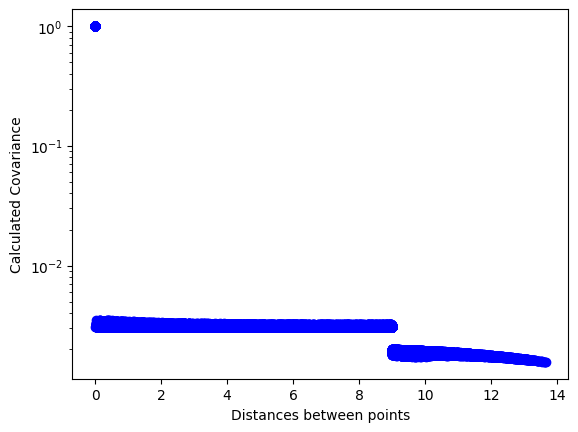

In [93]:
plt.scatter( data['Distances'], data['Calculated Covariance'], c='blue')
plt.yscale('log')
plt.ylabel('Calculated Covariance')
plt.xlabel('Distances between points')
plt.show()